# Env setup

In [1]:
import sys
from google.colab import drive
drive.mount('/content/A_drive')
sys.path.append('/content/A_drive/MyDrive/MLIS_car/src')
!pip install wandb -qqq
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install "opencv-python-headless<4.3"
import wandb
import pickle
import time
import tensorflow as tf
from tensorflow import keras
from datahandle import *
import datahandle
import importlib

Mounted at /content/A_drive
     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 181 kB 47.0 MB/s 
     |████████████████████████████████| 144 kB 48.6 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-o15sf43w
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-o15sf43w
     |████████████████████████████████| 47.8 MB 1.9 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=d0933b40b0dc217bedbc2cd5e8d5f84383fab28052b4b1af02a1e5c721800dac
  Stored in directory: /tmp/pip-ephem-wheel-cache-47ybill2/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successful

# Hyperparam setup

In [2]:
#hyper
root = '/content/A_drive/MyDrive/MLIS_car'
task_augmentation_dir= root+'/data/task_specific_augmentation/'
directory = root +'/data/A_training_given/training_data/'
training_folder = 'training_data'
training_labels_file= 'training_norm.csv'
#
collected_directory = root +'/data/Z_collected_raw/' 
made_directory = root +'/data/X_made_raw/' 

#
quiz_directory = root +'/data/C_testing_given/test_data/'
quiz_training_folder = 'test_data'
#configurations
conf_tracking = 1

# Dataloader setup

## loader objects

In [3]:
#dataloading object
training_object= datahandle.DataLoader_test(
        directory,
        training_folder,
        training_labels_file,
        task_augmentation_dir=task_augmentation_dir
        )
collected_object = datahandle.DataLoader_test(
        collected_directory,        
        task_augmentation_dir=task_augmentation_dir
        )
made_object = datahandle.DataLoader_test(
        made_directory,        
        task_augmentation_dir=task_augmentation_dir)
        

## function to get data information (not images)

In [4]:
def get_data_info(batch_size=32, split=0.8):
  made_train, made_test = made_object.LoadCollectedData_info(
          split=split,
          batch_size=batch_size) #for tf this batch size remains as 1
          
  collected_train, collected_test = collected_object.LoadCollectedData_info(
          split=split,
          batch_size=batch_size #for tf this batch size remains as 1
          )
  #train test split
  train,test = training_object.LoadModelData_info(
          split = split, 
          batch_size =batch_size)#for tf this batch size remains as 1
  return train,collected_train,test[0],collected_test[0],made_train,made_test[0]
a,b,c,d,e,f = get_data_info(batch_size=32, split=0.8)
example_batch = training_object.Load_batch(e[0], data_shape='original')

(344, 32, 4) (21, 32, 4) (2757, 4) (174, 4) (45, 32, 4) (360, 4)
(240, 320, 3)


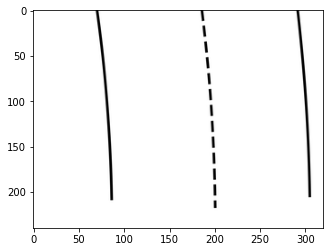

In [5]:
print(a.shape,b.shape,c.shape,d.shape,e.shape,f.shape)
print(example_batch[0][0].shape)
plt.imshow(example_batch[0][0])

# Model setup

## Function to get Pretrained model

In [6]:
def GetBaseModel(image_shape):
  Base = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
      input_shape=(240,240,3),
      include_top=False,weights='imagenet',
      pooling='avg'
  )
  Base.trainable = False
  return Base

## Function to build model

In [7]:
def BuildInitialModel(Base, image_shape, lr):
  inference_layer = tf.keras.layers.Dense(2, activation='relu')
  inputs = tf.keras.layers.Input(shape=image_shape)
  resize = tf.keras.layers.Resizing(
    240, 240, interpolation="bilinear", crop_to_aspect_ratio=False
)

  x = resize(inputs)
  x = Base(x)
  outputs = inference_layer(x)
  model = tf.keras.Model(inputs, outputs)
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])
  return model

# Function to replace last layer of model

## Function to make the pretrained model trainable

In [8]:
def MakeModelTunable(model,Base, tune_from, lr):
  Base.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = tune_from
  # Freeze all the layers before the `fine_tune_at` layer
  for layer in Base.layers[:fine_tune_at]:
    layer.trainable = False
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])
  return model, Base

# Tracking


In [39]:
#wandb tracking
if conf_tracking:
    config = {
     "model_type" : 'Transfer Learning with EfficentNetV2B0',
    }
    run = wandb.init(project="Autonomous-driving", entity="mo379",config=config)

# protocol programmable training loop

In [10]:
def protocol_training(model, protocol):
  for i,pro in enumerate(protocol):
    print(f'--- protocol step {i} using -> {pro}')
    ##Getting protocole variables
    tuning_starting_layer = pro['fine_tuning_start']
    n_epochs = pro['n_epochs']
    batch_size = pro['batch_size']
    split = pro['split']
    data_shape = pro['data_shape']
    learning_rate = pro['learning_rate']
    data_norm= pro['data_norm']
    data_col= pro['data_col']
    data_gen= pro['data_gen']
    augmentation_protocol = pro['augmentation_protocol']
    image_shape = (240,320,3)
    ###Setup up
    #setup the model either for fine tuning or from scratch
    ###
    if tuning_starting_layer:
      base = model.layers[2]
      model,base = MakeModelTunable(model,base, tuning_starting_layer,learning_rate)
    else:
      base = model.layers[2]
      model,base = MakeModelTunable(model,base, 313,learning_rate)
    
    
    #get the data
    train,train_collected,test,test_collected,train_gen,test_gen =  get_data_info(batch_size=batch_size,split=split)
    to_stack = [train,train_collected,train_gen]
    to_stack_test = [test,test_collected,test_gen]
    to_remove = []
    if data_norm ==0:
      to_remove.append(0)
    if data_col==0:
      to_remove.append(1)
    if data_gen ==0:
      to_remove.append(2)
    for index in sorted(to_remove, reverse=True):
      del to_stack[index] 
      del to_stack_test[index] 
    train_XY = np.vstack(to_stack) 
    
    if split < 1:
      test_XY = np.vstack(to_stack_test)
      rounded =  round(len(test_XY)/4)*4-4
      print(test_XY.shape, rounded)
      test_batches = test_XY[0:rounded].reshape(4,-1,4)
    # setup augmentation
    if augmentation_protocol:
      aug_status = True
      aug_protocol = augmentation_protocol
      aug_size = 256
    else:
      aug_status=False
      aug_protocol=[]
      aug_size = 256


    np.random.shuffle(train_XY)
    ### start ith protocol training
    for epoch in range(n_epochs):
        print(f'--- epoch {epoch}')
        for i in range(len(train_XY)):
            X,Y = training_object.Load_batch(train_XY[i], data_shape=data_shape, 
                                             augmentation=aug_status, augmentation_pass=1
                                             ,augmentation_protocol=aug_protocol,
                                             augmentation_size= aug_size)
            train_metrics = model.train_on_batch(X,Y, return_dict=True) 
            if i % 5 == 0:
                if split < 1:
                  X_test,Y_test = training_object.Load_batch(test_batches[np.random.randint(0,3)], data_shape=data_shape)
                  test_metrics = model.test_on_batch(
                      X_test, Y_test, sample_weight=None, reset_metrics=False, return_dict=True
                  )
                  test_loss = test_metrics['loss']
                batch_loss = train_metrics['loss']
                
                if conf_tracking==1:
                    wandb.log({"batch_loss": batch_loss})
                    if split < 1:
                      wandb.log({"test_loss": test_loss})
                      print(f'--- batch_loss {batch_loss}, test_loss {test_loss}')
                    else:
                      print(f'--- batch_loss {batch_loss}')
  return model

In [11]:
_path = root+'/pkls/B1_1_05_02.pkl'
model = keras.models.load_model(_path)
base = model.layers[1]
#image_shape = (240,320,3)
#base= GetBaseModel(image_shape)
#model = BuildInitialModel(base, image_shape, 0.0001)

28467200/28456008 [==============================] - 1s 0us/step


In [12]:
model.summary()
len(base.layers)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 240, 240, 3)       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 1280)             6931124   
 al)                                                             
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 6,933,686
Trainable params: 2,562
Non-trainable params: 6,931,124
_________________________________________________________________


314

In [41]:
protocol = [
    {'fine_tuning_start':313,'n_epochs':3, 'batch_size': 64,'split':0.8,
        'data_shape':'original','learning_rate':0.0001, 
        'data_norm':1,'data_col':0,'data_gen':0,
        
        'augmentation_protocol':
        ['Normal','TurnBias','StopGoLights','StopForObjec']},

    {'fine_tuning_start':250,'n_epochs':3, 'batch_size': 64,'split':0.8,
        'data_shape':'original','learning_rate':0.0001, 
        'data_norm':1,'data_col':0,'data_gen':0,
        
        'augmentation_protocol':
        ['Normal','TurnBias','StopGoLights','StopForObjec']},

    {'fine_tuning_start':290,'n_epochs':5, 'batch_size': 128,'split':0.8,
        'data_shape':'original','learning_rate':0.001, 
        'data_norm':1,'data_col':0,'data_gen':0,
        
        'augmentation_protocol':
        ['Normal']},
]
protocol = [
    {'fine_tuning_start':300,'n_epochs':3, 'batch_size': 64,'split':0.8,
        'data_shape':'original','learning_rate':0.0001, 
        'data_norm':1,'data_col':1,'data_gen':0,
        
        'augmentation_protocol':
        ['Normal']},
]

In [42]:
model = protocol_training(model,protocol)

--- protocol step 0 using -> {'fine_tuning_start': 300, 'n_epochs': 3, 'batch_size': 64, 'split': 0.8, 'data_shape': 'original', 'learning_rate': 0.0001, 'data_norm': 1, 'data_col': 1, 'data_gen': 0, 'augmentation_protocol': ['Normal']}
(2931, 4) 2928
--- epoch 0
--- batch_loss 0.01227443479001522, test_loss 0.01078567374497652
--- batch_loss 0.008550150319933891, test_loss 0.011839541606605053
--- batch_loss 0.00897816102951765, test_loss 0.011291560716927052
--- batch_loss 0.00504080718383193, test_loss 0.009146726690232754
--- batch_loss 0.0064777228981256485, test_loss 0.00938547495752573
--- batch_loss 0.005813665222376585, test_loss 0.009365791454911232
--- batch_loss 0.006453304551541805, test_loss 0.0095139155164361
--- batch_loss 0.005650319624692202, test_loss 0.010045942850410938
--- batch_loss 0.006235642358660698, test_loss 0.010081926360726357
--- batch_loss 0.07712835818529129, test_loss 0.020009830594062805
--- batch_loss 0.007929794490337372, test_loss 0.01032240409404

In [43]:
model_path = root+'/pkls/B1_1_05_03.pkl'
#model = tf.keras.models.load_model(model_path, custom_objects=None, compile=True, options=None)

tf.keras.models.save_model(
    model,
    model_path,
    overwrite=False,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

INFO:tensorflow:Assets written to: /content/A_drive/MyDrive/MLIS_car/pkls/B1_1_05_03.pkl/assets


In [44]:
run.finish()

batch_loss,▃▂▁▁▂▂▂▁▁▁▂▂▁▁▁▁▁▁▂▂▂▂▁█▁▁▁▁▁▁▁▂▁▁▁▂▇▁▁▁
test_loss,▃▄▂▃▃▃▃▂▁▁▂▂▂▂▂▁▂▂▂▂▂▂▁█▂▂▂▁▂▁▂▂▁▂▁▁▇▂▁▁
batch_loss,0.00547
test_loss,0.00902


# Loading the Quiz data

In [45]:
quiz_object= DataLoader_test(
    quiz_directory,
    quiz_training_folder,
)
data_shape = 'original'
quiz_train = quiz_object.LoadQuizData_info()
X,image_order = quiz_object.Load_batch_quiz(quiz_train,data_shape=data_shape)

# Making predictions

In [46]:
prds = model.predict(X)
final_prd = np.column_stack((image_order,prds))
final_ordered = final_prd[final_prd[:, 0].argsort()]
df = pd.DataFrame(final_ordered, columns = ['image_id','angle','speed'])
df = df.astype({'image_id': 'int32'})
df.to_csv(root+'/predictions/B1_1_05_03.csv', index=False,)

In [47]:
df

,image_id,angle,speed
0,1,0.706042,0.000000
1,2,0.794574,0.933333
2,3,0.261412,0.887478
3,4,0.108642,0.916532
4,5,0.136453,0.900996
...,...,...,...
1015,1016,0.405815,0.714037
1016,1017,0.747216,0.134150
1017,1018,0.383388,0.864751
1018,1019,0.291353,0.812064


# Dataloader

In [20]:
import os
import sys
import glob
import random
import numpy as np
from numpy import genfromtxt
from numpy import asarray
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
import albumentations as album

class DataLoader_test:
    def __init__(self, directory, images_dir='',labels_file='',task_augmentation_dir=''):
        self.directory = directory
        self.task_aug_dir = task_augmentation_dir
        self.images_dir = images_dir
        self.labels_file= labels_file

    def Load_all_batches(self, data, data_shape=(-1,1)):
        loaded_set_features = []
        loaded_set_labels= []
        for batch in data:
            X = []
            Y = []
            for instance in batch:
                link = instance[0]
                image = Image.open(link)
                data = asarray(image)
                if data.shape[2] == 4:
                    data = data[:,:,:-1]
                if data_shape != 'original':
                    data = data.reshape(data_shape)
                X.append(data)
                image_number = instance[1]
                angle = instance[2]
                speed = instance[3]
                Labels = np.array([angle,speed], dtype=np.float32)
                Y.append(Labels)
            loaded_set_features.append(X)
            loaded_set_labels.append(Y)
        loaded_set_features = np.array(loaded_set_features,dtype=np.uint8)
        loaded_set_labels= np.array(loaded_set_labels,dtype=np.float32)
        return loaded_set_features,loaded_set_labels

    def Load_batch(self, batch, data_shape=(-1,1), augmentation=False, 
                   augmentation_pass = 1,augmentation_protocol=[], 
                   augmentation_size=256):
        X = []
        Y = []
        for instance in batch:
            link = instance[0]
            image = Image.open(link)
            data = asarray(image)
            if data.shape[2] == 4:
                data = data[:,:,:-1]
            if data_shape != 'original':
                data = data.reshape(data_shape)
            X.append(data)
            image_number = instance[1]
            angle = instance[2]
            speed = instance[3]
            Labels = np.array([angle,speed], dtype=np.float32)
            Y.append(Labels)
        if augmentation:
            X,Y = self._augment_batch(X,Y, n=augmentation_pass,
                                      protocol=augmentation_protocol
                                      ,target_aug_batch_size = augmentation_size)
        loaded_set_features = np.array(X,dtype=np.uint8)
        loaded_set_labels= np.array(Y,dtype=np.float32)
        return loaded_set_features,loaded_set_labels

    def Load_batch_quiz(self, batch, data_shape=(-1,1)):
        X = []
        Image_order = []
        for instance in batch:
            link = instance[0]
            image = Image.open(link)
            data = asarray(image)
            if data.shape[2] == 4:
                data = data[:,:,:-1]
            if data_shape != 'original':
                data = data.reshape(data_shape)
            image_number = instance[1]
            X.append(data)
            Image_order.append(image_number)
        X = np.array(X)
        Image_order = np.array(Image_order)
        return X,Image_order

    def LoadCollectedData_info(self,split,batch_size):
        self._get_collected_imgsinfo_train()
        if split:
            self._train_test_split(split=split)
        if batch_size:
            self._batch_imgsinfo_train(batch_size=batch_size)
        return self.train_images_information, np.array([self.test_images_information])

    def LoadModelData_info(self, split, batch_size):
        self._get_imgsinfo_train()
        if split:
            self._train_test_split(split=split)
        if batch_size:
            self._batch_imgsinfo_train(batch_size=batch_size)
        return self.train_images_information, np.array([self.test_images_information])

    def LoadQuizData_info(self):
        self._get_imgsinfo_test()
        return self.quiz_images_information

    def _train_test_split(self, split):
        n = len(self.train_images_information)
        split_index = int(np.ceil(n * split))
        train_split = self.train_images_information[0:split_index]
        test_split = self.train_images_information[split_index+1:n]
        self.train_images_information = train_split
        self.test_images_information = test_split

    def _batch_imgsinfo_train(self, batch_size):
        n = len(self.train_images_information)
        if n % batch_size ==0:
            batched_imgsinfo_train = np.reshape(self.train_images_information,
                    (int(n/batch_size),-1,4)
                    )
        else: 
            while n % batch_size != 0:
                n -= 1
            batched_imgsinfo_train = np.reshape(
                    self.train_images_information[0:n],
                    (int(n/batch_size),-1,4)
                    )
        self.train_images_information = batched_imgsinfo_train

    def _get_collected_imgsinfo_train(self):
        #Get the absolute paths of the data
        absolute_paths = glob.glob(self.directory+"/*.png") 
        #getting the labels
        self.train_images_information= []
        for path in absolute_paths:
            parts = path.split('/')[-1].split('.')[0].split('_')
            image_number= parts[0]
            angle = parts[1]
            angle = round((int(angle)-50)/(120-50),3)
            speed = parts[2]
            speed = round(int(speed)/35, 3)
            if speed < 0.5:
                speed = round(np.random.uniform(low=0.0, high=0.15),3)
            else:
                speed = round(np.random.uniform(low=0.85, high=1),3)
            information =[ 
                    path,
                    image_number,
                    angle,
                    speed
                    ]
            self.train_images_information.append(information)

    def _get_imgsinfo_train(self):
        #Get the absolute paths of the data
        absolute_paths = glob.glob(self.directory+self.images_dir+"/*.png") 
        #getting the labels
        labels = self._get_labels()
        df = pd.DataFrame(labels, columns = ['index','angle','speed'])
        df = df.set_index('index')
        self.train_images_information= []
        for path in absolute_paths:
            parts= path.split('/')
            image_name = parts[-1]
            image_number = int(image_name.split('.')[0])
            if image_number in df.index:
                image_label = df.loc[image_number]
            else:
                continue
            angle = image_label[0]
            speed = image_label[1]
            if speed < 0.5:
                speed = round(np.random.uniform(low=0.0, high=0.15),3)
            else:
                speed = round(np.random.uniform(low=0.85, high=1),3)

            information =[ 
                    path,
                    image_number,
                    angle,
                    speed
                    ]
            self.train_images_information.append(information)

    def _get_imgsinfo_test(self):
        #Get the absolute paths of the data
        absolute_paths = glob.glob(self.directory+self.images_dir+"/*.png") 
        #getting the labels
        self.quiz_images_information= []
        for path in absolute_paths:
            parts= path.split('/')
            image_name = parts[-1]
            image_number = int(image_name.split('.')[0])
            information =[ 
                    path,
                    image_number,
                    ]
            self.quiz_images_information.append(information)

    def _get_labels(self):
        labels = genfromtxt(self.directory+self.labels_file , delimiter=',' , skip_header=1, dtype=np.float32) 
        return labels
        
        
    #augmentation_protocol options
    ## Normal, TurnBias, StopGoLights, SyntheticStopGoLights,
    ## StopForObjec, MirrorSteeringFlip
    def _augment_batch(self, X,Y,n,protocol,target_aug_batch_size):
        Xs = []
        Ys = []
        sx,sy = 90,140
        pro_copy = protocol
        for _ in range(n):
            for x,y in zip(X,Y):
                if len(Xs) < target_aug_batch_size:
                  x, y= self._unit_augment_album_invert(x,y)
                  Xs.append(x)
                  Ys.append(y)
                  protocol = [random.choice(tuple(pro_copy))]
                  if 'Normal' in protocol:
                    x_album, y_album = self._unit_augment_album(x,y)
                    Xs.append(x_album)
                    Ys.append(y_album)
                  if 'TurnBias' in protocol:
                    x_turn, y_turn = self._unit_augment_turn(x,y,sx,sy)
                    Xs.append(x_turn)
                    Ys.append(y_turn)
                  if 'StopGoLights' in protocol:
                    x_light, y_light = self._unit_augment_light(x,y,sx,sy)
                    Xs.append(x_light)
                    Ys.append(y_light)
                  if 'SyntheticStopGoLights' in protocol:
                    x_slight, y_slight = self._unit_augment_slight(x,y)
                    Xs.append(x_slight)
                    Ys.append(y_slight)
                  if 'StopForObjec' in protocol:
                    x_ostop, y_ostop = self._unit_augment_object_stop(x,y,sx,sy)
                    Xs.append(x_ostop)
                    Ys.append(y_ostop)
                  if 'MirrorSteeringFlip' in protocol:
                    x_mirror,y_mirror = self._unit_augment_mirror(x,y)
                    Xs.append(x_mirror)
                    Ys.append(y_mirror)
                else:
                  pass
        if len(Xs) > target_aug_batch_size:
          n = len(Xs) - target_aug_batch_size
          def delete_rand_items(Xs,Ys,n):
            to_delete = set(random.sample(range(len(Xs)),n))
            return [x for i,x in enumerate(Xs) if not i in to_delete],[y  for i,y in enumerate(Ys) if not i in to_delete] 
          Xs,Ys = delete_rand_items(Xs,Ys,n)
        return Xs,Ys
    
    def _unit_augment_album(self, x,y):
        transform = album.Compose([
            album.OneOf([
                album.MotionBlur(always_apply=False, p=1.0, blur_limit=(3, 7)),
                album.RandomBrightnessContrast(always_apply=False, p=1.0, 
                                                brightness_limit=(-0.2, 0.2), 
                                                contrast_limit=(-0.2, 0.2), brightness_by_max=True),
                album.Rotate(always_apply=False, p=1.0, limit=(-31, 31), 
                                interpolation=0, border_mode=1, 
                                value=(0, 0, 0), mask_value=None),
                album.RandomResizedCrop(always_apply=False, p=1.0, 
                                        height=240, width=320, scale=(0.5399999618530273, 1.0), 
                                        ratio=(0.7299999594688416, 2.259999990463257), interpolation=1),
                album.CoarseDropout(always_apply=False, p=1.0, max_holes=28, max_height=8, max_width=8, 
                                    min_holes=15, min_height=8, min_width=8)

            ])
        ])
        x_basic, y_basic = transform(image=x)['image'], y
        return x_basic, y_basic

    def _unit_augment_album_invert(self, x,y):
        transform = album.Compose([
            album.InvertImg(always_apply=False, p=1.0)
        ])
        x_basic, y_basic = transform(image=x)['image'], y
        return x_basic, y_basic
    
    def _unit_augment_turn(self,x,y,sx,sy):
      objects = ['steer_left.png','steer_right.png']
      rand = np.random.randint(0,1)
      input = Image.open(os.path.join(self.task_aug_dir,objects[rand]))
      input = np.asarray(input.resize((sx,sy)))[:,:,:]
      #x = cv2.cvtColor(x, cv2.COLOR_RGB2RGBA)
      region=(0,(320-sx-5),0,(240-sy-5))
      x_new = self._placeimage_A_in_B(input,x,region=region)
      y = y.copy()
      if rand ==0:
        y[0] = np.random.uniform(0,0.25)
      elif rand ==1:
        y[0] = np.random.uniform(0.75,1)
      return x_new,y
    
    def _unit_augment_light(self,x,y,sx,sy):
      objects = ['green_light.png','red_light.png']
      rand = np.random.randint(0,1)
      input = Image.open(os.path.join(self.task_aug_dir,objects[rand]))
      input = np.asarray(input.resize((sx,sy)))[:,:,:]
      #x= cv2.cvtColor(x, cv2.COLOR_RGB2RGBA)
      region=(0,(320-sx-5),0,(240-sy-5))
      x_new = self._placeimage_A_in_B(input,x,region=region)
      y = y.copy()
      if rand ==0:
        pass
      elif rand ==1:
        y[0] = 0
      return x_new,y
    
    def _unit_augment_slight(self, x,y):
        #takes a single image and mirrors it while flipping the steering angle
        def rand_light_gen():
            #creates random light, returns light and status
            light_size = np.random.randint(10,20)
            _light = np.zeros((light_size,light_size,3))
            red_light = _light[:] + (255,0,0)
            green_light = _light[:] + (0,255,0)
            rand = np.random.uniform(0,1)
            if rand >= 0.5:
                return green_light,'go'
            else:
                return red_light,'stop'
        def add_light_rand(image):
            #adds light to image, returns image
            light, status = rand_light_gen()
            size = light.shape[0]
            light_field_x = int(np.round(image.shape[0]*0.6))
            light_field_y = int(image.shape[1])
            x_start = np.random.randint(0+(size+1),light_field_x-(size-1))
            x_end = x_start + size
            y_start = np.random.randint(0+(size+1),light_field_y-(size-1))
            y_end = y_start + size
            image = image.copy()
            image[x_start:x_end,y_start:y_end,:] = light
            return image, status
        x_new, status = add_light_rand(x)
        if status == 'stop':
            y = y.copy()
            y[1] = 0
        return x_new,y
    
    def _unit_augment_object_stop(self, x,y, sx,sy):
        #takes a single image and mirrors it while flipping the steering angle
        objects = ['person_stop.png','tree_stop.png','person_stop2.png','box_stop.png']
        rand = np.random.randint(0,1)
        input = Image.open(os.path.join(self.task_aug_dir,objects[rand]))
        input = np.asarray(input.resize((sx,sy)))[:,:,:]
        #x= cv2.cvtColor(x, cv2.COLOR_RGB2RGBA)
        region=(0,(320-sx-5),0,(240-sy-5))
        x_new = self._placeimage_A_in_B(input,x,region=region)
        y = y.copy()
        y[0] = 0
        return x_new,y
    
    def _unit_augment_mirror(self, x,y):
        #takes a single image and mirrors it while flipping the steering angle
        transform = album.Compose([
            album.HorizontalFlip(p=1),
        ])
        new = transform(image=x)['image']
        y = y.copy()
        y[0] = (y[0]*-1) +1 
        return new,y
        
    def _placeimage_A_in_B(self,A,B, region):
            #adds light to image, returns image
            input = A
            image = B
            #
            size = input.shape
            x_start = np.random.randint(region[0],region[1])
            x_end = x_start + size[1]
            y_start = np.random.randint(region[2],region[3])
            y_end = y_start + size[0]
            image = image.copy()
            image[y_start:y_end,x_start:x_end,:] = input[:,:,0:3]
            return image






In [21]:
#dataloading object
test_object= DataLoader_test(
        directory,
        training_folder,
        training_labels_file,
        task_augmentation_dir=task_augmentation_dir
        )
collected_object = DataLoader_test(
        collected_directory,
        task_augmentation_dir=task_augmentation_dir
        )      
        
def get_data_info_tes(batch_size=32, split=0.8):
  collected_train, collected_test = collected_object.LoadCollectedData_info(
          split=split,
          batch_size=batch_size #for tf this batch size remains as 1
          )
  #train test split
  train,test = test_object.LoadModelData_info(
          split = split, 
          batch_size =batch_size)#for tf this batch size remains as 1
  return train,collected_train,test[0],collected_test[0]
a,b,c,d,e,f = get_data_info(batch_size=32, split=0.8)
aug_size = 256
aug_protocol = ['']
example_batch_X,example_batch_Y = test_object.Load_batch(a[1], data_shape='original',
                                             augmentation=True, augmentation_pass=5
                                             ,augmentation_protocol=aug_protocol, 
                                             augmentation_size = aug_size)

In [22]:
example_batch_X.shape
print(test_object.directory)

/content/A_drive/MyDrive/MLIS_car/data/A_training_given/training_data/


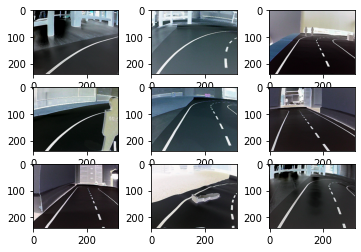

In [23]:
ex = 45
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(example_batch_X[0])
axarr[0,1].imshow(example_batch_X[1])
axarr[0,2].imshow(example_batch_X[2])
axarr[1,0].imshow(example_batch_X[3])
axarr[1,1].imshow(example_batch_X[4])
axarr[1,2].imshow(example_batch_X[5])
axarr[2,0].imshow(example_batch_X[6])
axarr[2,1].imshow(example_batch_X[7])
axarr[2,2].imshow(example_batch_X[8])

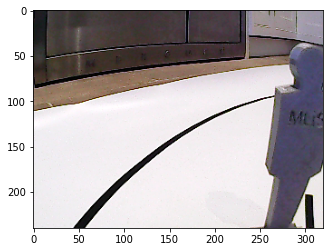

In [24]:
ex = example_batch_X[3]
ex = tf.bitwise.invert(
    ex, name=None
)
plt.imshow(example_batch_X[3])
plt.imshow(ex)

# Feature trainer